# Natural Language Processing (NLP)
[SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [1]:
import nltk

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
sms = [line for line in open('smsspamcollection/SMSSpamCollection')]

In [4]:
len(sms), type(sms)

(5574, list)

In [5]:
sms[1]

'ham\tOk lar... Joking wif u oni...\n'

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                names=['target', 'sms'])
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
target    5572 non-null object
sms       5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [9]:
df.describe()

,target,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
df.groupby('target').describe()

sms                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

## Feature Engineering

In [11]:
df['length'] = df['sms'].apply(len)
df.head()

,target,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

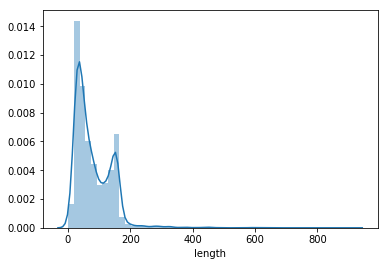

In [13]:
sns.distplot(df['length']);

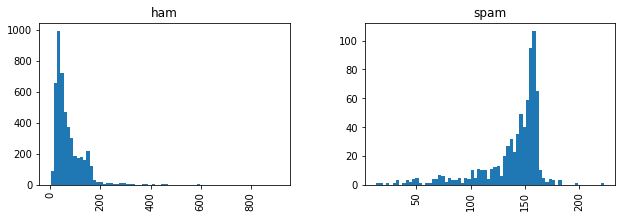

In [14]:
df.hist(column='length', by='target', bins=70,figsize=(10,3));

## Text Preprocessing 

In [15]:
import string
string.punctuation
from nltk.corpus import stopwords

#### Removing punctuations, Removing stop-words

In [16]:
def process_text(raw_text):
    # Check for the punctuations 
    nopunc = [char for char in raw_text 
              if char not in string.punctuation]
    # Join the characters 
    nopunc = ''.join(nopunc)
    # Remove stopwords (if any)
    return [word for word in nopunc.split() 
            if word.lower() not in stopwords.words('english')]

### Tokenization

In [17]:
df['sms'].apply(process_text);

In [18]:
df.head()

,target,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Vectorization

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
bow_transformer = CountVectorizer(analyzer=process_text).fit(df['sms'])

In [21]:
print(len(bow_transformer.vocabulary_))

11425


In [22]:
type(bow_transformer.vocabulary_)
bow_transformer.vocabulary_.get('way')

10979

In [23]:
print(bow_transformer.get_feature_names()[10979])

way


In [24]:
df_bow = bow_transformer.transform(df['sms'])

In [25]:
print('Shape of matrix of token counts(sms_bow): ', df_bow.shape)
print('No of Non-Zero elements: ', df_bow.nnz)

Shape of matrix of token counts(sms_bow):  (5572, 11425)
No of Non-Zero elements:  50548


In [26]:
total_no_of_elements = df_bow.shape[0] * df_bow.shape[1]
sparsity = (df_bow.nnz / total_no_of_elements)*100
print('sparsity of df_bow matrix: {}' .format(sparsity))

sparsity of df_bow matrix: 0.07940295412668218


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

In [28]:
tfidf_trans = TfidfTransformer()
tfidf_trans.fit(df_bow)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [29]:
print('IDF for "Way" is: ',tfidf_trans.idf_[bow_transformer.vocabulary_['way']])

IDF for "Way" is:  5.0613405961017


In [30]:
df_tfidf = tfidf_trans.transform(df_bow)

In [31]:
df_tfidf.shape

(5572, 11425)

## Machine Learning -- Training and evaluating the model  

In [32]:
from sklearn.model_selection import train_test_split 
X = df_tfidf
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
from sklearn.naive_bayes import MultinomialNB
spam_ham_detection = MultinomialNB()
spam_ham_detection.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Evaluation**

In [34]:
pred = spam_ham_detection.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(y_test, pred))
print (classification_report(y_test, pred))

[[1593    0]
 [  71  175]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1593
        spam       1.00      0.71      0.83       246

   micro avg       0.96      0.96      0.96      1839
   macro avg       0.98      0.86      0.90      1839
weighted avg       0.96      0.96      0.96      1839



## [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) 


In [36]:
X = df['sms']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
from sklearn.pipeline import Pipeline

In [38]:
pipeline = Pipeline([
    # Tokenization using scikit's CountVectorizer 
    ('baw', CountVectorizer(analyzer=process_text)),  
    
    # Computing TF-IDF  -- weighted scores
    ('tfidf', TfidfTransformer()),  
    
     # Naive Bayes classifier to train on TF-IDF vectors
    ('model_nb', MultinomialNB()), 
])

**Traing / Fitting using pipeline**

In [39]:
pipeline.fit(X_train,y_train)
pred = pipeline.predict(X_test)

**Evaluation**

In [40]:
print (confusion_matrix(y_test, pred))
print (classification_report(y_test, pred))

[[1593    0]
 [  65  181]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1593
        spam       1.00      0.74      0.85       246

   micro avg       0.96      0.96      0.96      1839
   macro avg       0.98      0.87      0.91      1839
weighted avg       0.97      0.96      0.96      1839



### Logistic Regression Classifier

In [41]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('baw', CountVectorizer(analyzer=process_text)),  
    ('tfidf', TfidfTransformer()),  
    
     # only change is RandomForestClassifier() 
    ('model', LogisticRegression()), 
])
# training the model
pipeline.fit(X_train,y_train)
# doing predictions
pred = pipeline.predict(X_test)
#Evaluation
print (confusion_matrix(y_test, pred))
print (classification_report(y_test, pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[1589    4]
 [  91  155]]
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1593
        spam       0.97      0.63      0.77       246

   micro avg       0.95      0.95      0.95      1839
   macro avg       0.96      0.81      0.87      1839
weighted avg       0.95      0.95      0.94      1839



### Random Forests Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('baw', CountVectorizer(analyzer=process_text)),  
    ('tfidf', TfidfTransformer()),  
    
     # only change is RandomForestClassifier() 
    ('model', RandomForestClassifier()), 
])

# training the model
pipeline.fit(X_train,y_train)
# doing predictions
pred = pipeline.predict(X_test)
#Evaluation
print (confusion_matrix(y_test, pred))
print (classification_report(y_test, pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1593    0]
 [  67  179]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1593
        spam       1.00      0.73      0.84       246

   micro avg       0.96      0.96      0.96      1839
   macro avg       0.98      0.86      0.91      1839
weighted avg       0.97      0.96      0.96      1839

